# Chapter3. 使用scikit-learn实现机器学习分类算法

## 1. 分类算法的选择
训练机器学习算法的步骤：
    1. 特征选择
    2. 确定性能评价标准
    3. 选择分类器及其优化算法
    4. 对模型性能的评估调优
    5. 算法的调优

## 2. 使用scikit-learn训练感知器

In [2]:
from sklearn import datasets
import numpy as np

iris = datasets.load_iris()
# 选择鸢尾花数据的第3和4列特征
X = iris.data[:, [2, 3]]
y = iris.target
# 输出标签种类
print('Class labels:', np.unique(y))

Class labels: [0 1 2]


将数据集分为训练集(70%)和测试集(30%)

In [3]:
# 书中的train_test_split模块所属发生了更改
# from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
         X, y, test_size=0.3, random_state=0)

标准化特征值

In [4]:
from sklearn.preprocessing import StandardScaler

# 使用默认参数初始化
sc = StandardScaler()
# 使用fit方法计算训练数据中每个特征的均值和标准差
sc.fit(X_train)

X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

 在调用完fit方法计算出均值和标准差后，再使用transform方法使用上面计算出的均值和标准差对训练数据和测试数据做标准化处理。<br>
 这里要注意使用相同的样本均值和标准差来处理测试数据和训练数据，保证他们同倍缩放。在处理完数据后就可以训练感知器模型了。

In [5]:
from sklearn.linear_model import Perceptron

ppn = Perceptron(n_iter=40, eta0=0.1, random_state=0)
ppn.fit(X_train_std, y_train)

Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=0.1,
      fit_intercept=True, max_iter=None, n_iter=40, n_iter_no_change=5,
      n_jobs=None, penalty=None, random_state=0, shuffle=True, tol=None,
      validation_fraction=0.1, verbose=0, warm_start=False)

从上面可以看出sklearn.linear_model.Perceptron的选项。其中random_state用于在每次迭代后初始化重排数据训练数据集

In [6]:
y_test.shape   # 测试集的数量

(45,)

In [7]:
# 使用predict方法进行预测
y_pred = ppn.predict(X_test_std)
print('Misclassified samples: %d' % (y_test != y_pred).sum())

Misclassified samples: 9


在对45朵花的分类中错了9个，错误率为9/45=0.20，准确率为1 - 1/5 = 0.80<br><br>
在metrics模块中，sklearn还实现了不同的性能矩阵，可以直观的看出分类器性能。

In [8]:
from sklearn.metrics import accuracy_score
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))

Accuracy: 0.80


下面绘制数据集和决策边界

In [37]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import warnings


def versiontuple(v):
    return tuple(map(int, (v.split("."))))


def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, color=cmap(idx), s=30,
                    marker=markers[idx], label=cl)

    # 高亮显示测试数据
    if test_idx:
        # 使用versiontuple判断numpy的版本，如果版本低于1.9.0那么抛出warning
        if not versiontuple(np.__version__) >= versiontuple('1.9.0'):
            X_test, y_test = X[list(test_idx), :], y[list(test_idx)]
            warnings.warn('Please update to NumPy 1.9.0 or newer')
        else:
            X_test, y_test = X[test_idx, :], y[test_idx]

        # 这里不能讲颜色选项设置为空，不然会显示不出来，所以挑了个颜色
        # alpha表示标记点的颜色强度，越小颜色越轻
        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    color='cyan',
                    alpha=0.6,
                    linewidths=1,
                    marker='v',
                    s=30, label='test set')

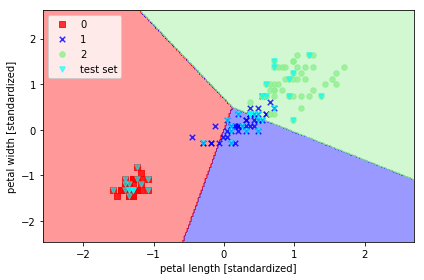

In [38]:
# 把测试集和训练集组合在一起
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

plot_decision_regions(X=X_combined_std, y=y_combined,
                      classifier=ppn, test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

从结果可以看出，无法通过一个线性的感知器来完美区分三类样本。

## 2. 逻辑回归中的类别概率
### a. Sigmoid曲线

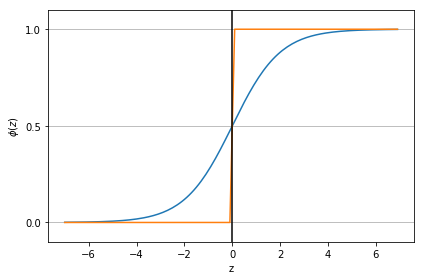

In [39]:
import matplotlib.pyplot as plt
import numpy as np

def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

z = np.arange(-7, 7, 0.1)
phi_z = sigmoid(z)
phi_z0 = sigmoid(100 * z)

plt.plot(z, phi_z)
plt.plot(z, phi_z0)
plt.axvline(0.0, color='k')
# 设置y坐标的范围，头尾多画一点
plt.ylim(-0.1, 1.1)
plt.xlabel('z')
plt.ylabel('$\phi (z)$')

# 设置y轴显示的坐标值
plt.yticks([0.0, 0.5, 1.0])
# gca方法获取当前坐标轴
ax = plt.gca()
# 获取坐标轴后，在y轴上显示网格
ax.yaxis.grid(True)

# tight_layout方法会自动调整子图参数，使之填充整个图像区域
plt.tight_layout()
plt.show()

可以看到，当$z$趋于无穷大时，$\phi(z)$趋于1，反之趋于0，另外，当z前面有系数的时候，系数越大，函数曲线越陡峭。

### b. 通过代价函数获得权重
$$ J(\phi(z), y; w)= \begin{cases} -log(\phi(z))  & \text {if $y=1$} \\ -log(1-\phi(z))  & \text{if $y=0$} \end{cases} $$

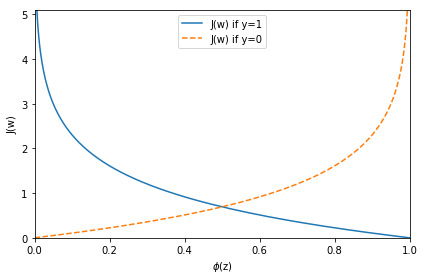

In [40]:
def cost_1(z):
    return -np.log(sigmoid(z))

def cost_0(z):
    return -np.log(1 - sigmoid(z))

z = np.arange(-10, 10, 0.1)
phi_z = sigmoid(z)

c1 = [cost_1(x) for x in z]
plt.plot(phi_z, c1, label='J(w) if y=1')

c0 = [cost_0(x) for x in z]
plt.plot(phi_z, c0, linestyle='--', label='J(w) if y=0')

plt.ylim(0.0, 5.1)
plt.xlim([0, 1])
plt.xlabel('$\phi$(z)')
plt.ylabel('J(w)')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

$z$ 不断变大时，根据sigmoid函数，会将类别判定为1，这时代价函数 $J$ 中的 $y=1$ ， $J$ 随着 $z$ 的增长减小，但是如果判断错误，也就是 $y=0$，那么代价函数就会增大，那么最小化代价函数就会把结果往正确的方向修正。

### c. 使用sklearn训练逻辑回归模型

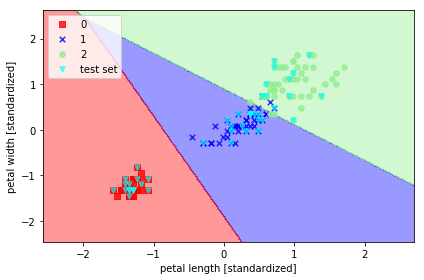

In [41]:
from sklearn.linear_model import LogisticRegression

# C为正则化项
# 书中没有solver和multi_class选项，抛出了FutureWarning警告
lr = LogisticRegression(C=1000.0, solver='liblinear', multi_class='auto', random_state=0)
lr.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, y_combined,
                      classifier=lr, test_idx=range(105, 150))

plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

可以看出逻辑回归也是一个线性模型。<br>
上面的liblinear是台湾大学使用C/C++开发的高度优化的库，另外类似的还有libsvm。它们与原生的Python代码实现的分类器相比，在用于大型数据时，可以获得极高的训练速度。然而遇到数据量过大，可能会无法加载到内存中。针对这种情况，sklearn提供了SGDClassifier类供用户使用，它还可以通过partial_fit方法支持在线学习。可以按照如下方法使用它：
```
from sklearn.linear_model import SGDClassifier
ppn = SGDClassifier(loss='perceptron')
lr = SGDClassifier(loss='log')
svm = SGDClassifier(loss='hinge')
```

In [42]:
# 预测第一个样本的概率
# 现在的predict_proba只识别2-D数据，
# lr.predict_proba(X_test_std[0,:])
lr.predict_proba(X_test_std[0,:].reshape(1, -1))

array([[1.78177322e-11, 6.12453348e-02, 9.38754665e-01]])

下面是0.17版本的sklearn中抛出的警告，到了0.19版本就直接抛出错误，以后需要注意。<br>
DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.<br><br>

上面输出的数组第三个元素表明当前样本属于第3个类别的概率为93.9%，第2个类别的概率为6.1%，基本不可能属于第一类。

In [43]:
print(lr.coef_)

[[-7.17909286 -6.81412164]
 [ 2.57725913 -2.37822768]
 [ 9.46639729  6.43327101]]


这里解释一下coef_的维度问题。可以看到coef_是3 × 2的，coef_[i]分别代表着属于第i个类别的权重参数，这里有三个类别，所以会输出三个权重参数。当使用他们计算Sigmoid函数的输出时，会输出三个概率，分别是属于这三个类别的概率值。

### d. 使用正则化解决过拟合问题

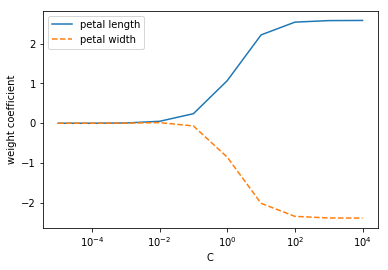

In [44]:
weights, params = [], []
for c in np.arange(-5, 5):
    # 生成一个从-5到5的正则化项列表，共10个，带入到模型中进行计算
    # 注意，C是逆正则化项，也就是乘在原代价函数位置的，不是权重向量，C=1/lambda
    # 这里和书中不同，不允许用整数进行负平方，也就是10 ** c是不允许的。把10改为浮点数即可
    lr = LogisticRegression(C=10.0 ** c, solver='liblinear', multi_class='auto', random_state=0)
    lr.fit(X_train_std, y_train)
    # weights保存了这些具有不同正则化项模型的权重系数
    # 使用第二个类别的权重参数绘制图像
    weights.append(lr.coef_[1])
    params.append(10.0 ** c)
    
weights = np.array(weights)
plt.plot(params, weights[:, 0], label='petal length')
plt.plot(params, weights[:, 1], linestyle='--', label='petal width')
plt.ylabel('weight coefficient')
plt.xlabel('C')
plt.legend(loc='upper left')
# 设置x轴坐标的单位为log(x)
plt.xscale('log')
plt.show()

可以看到，当C增大时，$\lambda$减小，正则化的影响变小，模型方差增大。当C减小时，$\lambda$增大，正则化影响变大，系数开始缩减，直至接近0.<br><br>
为什么正则化项会影响系数呢。从正则化后的代价函数可以看出，当正则参数变小，也就是$\lambda$变大，在最小化代价函数的过程中，就会努力将系数变小。例如L2正则，那么在最小化代价函数时，如果使用梯度下降的方法，参数的梯度为$\lambda{w}$，$\lambda$较大，那么$w$缩减的速度就越快。同时，如果对代价函数求偏导，并令它等于0，可以得到$\lambda$的表达式：
$$\lambda = \frac*{w}$$
可以看出，为了最小化*，同时$\lambda$也要变大，那么${w}$会趋于0。

## 3. 使用支持向量机最大化分类间隔
### a. 线性支持向量机

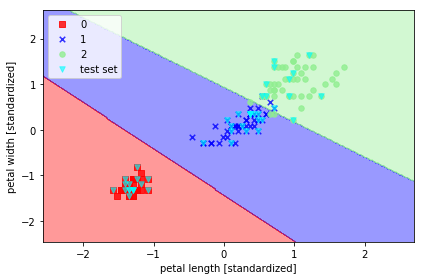

In [45]:
from sklearn.svm import SVC

# C为松弛变量
svm = SVC(kernel='linear', C=1.0, random_state=0)
svm.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, y_combined, 
                      classifier=svm, test_idx=range(105, 150))

plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

### b. 使用核函数解决非线性问题
首先生成一组非线性可分的数据。

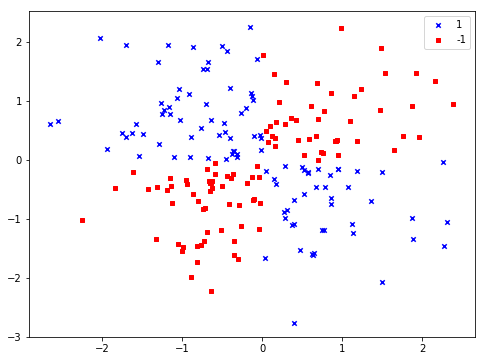

In [49]:
# 我们设置相同的seed，每次生成的随机数相同。如果不设置seed，则每次会生成不同的随机数
np.random.seed(0)
# randn返回标准正态分布，200是样本量，2是特征数
# 此处默认为N(0, 1)，如果想要改变均值和方差，可以如下进行：
# sigma * np.random.randn(...) + mu
# numpy.random.randn(d0, d1, …, dn)是从标准正态分布中返回一个或多个样本值。 
# numpy.random.rand(d0, d1, …, dn)的随机样本位于[0, 1)中。
X_xor = np.random.randn(200, 2)

# y_xor是X_xor所有大于0的样本进行逻辑异或得到，图中也可以看出，呈对角线分布
y_xor = np.logical_xor(X_xor[:, 0] > 0, X_xor[:, 1] > 0)
y_xor = np.where(y_xor, 1, -1)

plt.figure(figsize=(8, 6))
plt.scatter(X_xor[y_xor == 1, 0], X_xor[y_xor == 1, 1],
            color='b', marker='x', s=20, label='1')
plt.scatter(X_xor[y_xor == -1, 0], X_xor[y_xor == -1, 1], 
            color='r', marker='s', s=20, label='-1')
plt.ylim(-3.0)
plt.legend()
plt.show()

从上图可以看到，使用前面的线性逻辑回归和支持向量机无法将正负样本正确划分。可以使用核方法把样本空间映射到高维，并在高维空间内找到线性可分的超平面将数据正确划分。<br><br>
一个最广为使用的核函数就是径向基函数核(Radial Basis Function kernel, RBF)：
$$k(x^{(i)}, x^{(j)})=exp(-\frac{{||x^{(i)} - x^{(j)}||}^2}{2\delta^2})$$
或者简写为：
$$k(x^{(i)}, x^{(j)})=exp(-\gamma{||x^{(i)} - x^{(j)}||}^2)$$
其中$\gamma=\frac1{2\delta^2}$是待优化的自由参数。

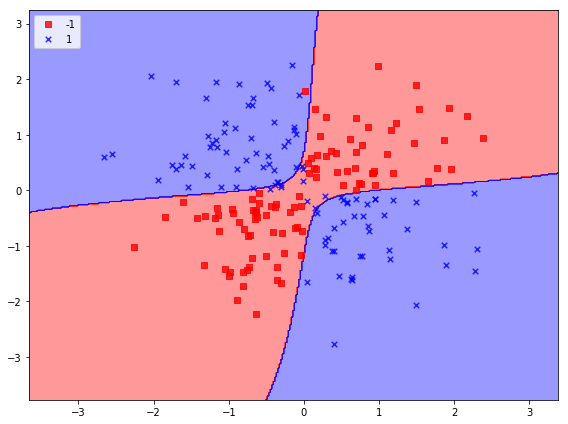

In [50]:
# 把kernel参数改为rbf
svm = SVC(kernel='rbf', random_state=0, gamma=0.10, C=10.0)
svm.fit(X_xor, y_xor)
plt.figure(figsize=(8, 6))
plot_decision_regions(X_xor, y_xor, classifier=svm)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

把核方法应用到前面鸢尾花的数据上：

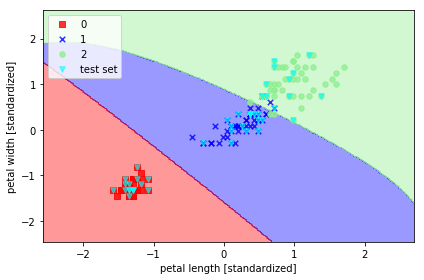

In [51]:
svm = SVC(kernel='rbf', random_state=0, gamma=0.2, C=1.0)
svm.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, y_combined,
                      classifier=svm, test_idx=range(105,150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

可以看到，使用较小的$\gamma$值，产生了非线性决策边界，但是不是很明显，如果增大$\gamma$值，也就是减小$\delta$，会使得高斯核变得更加“陡峭”，会增大模型的方差，产生过拟合。

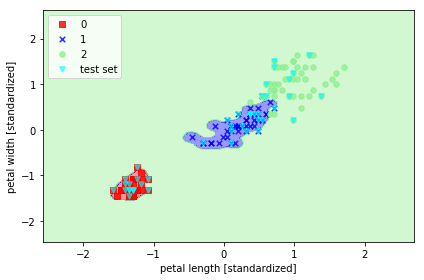

In [52]:
svm = SVC(kernel='rbf', random_state=0, gamma=100.0, C=1.0)
svm.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, y_combined, 
                      classifier=svm, test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

当$\gamma=100$时，方差过高，发生了严重的过拟合现象。

## 4. 决策树
### a. 决策树基本知识
决策树模型具有很强的可解释性，它可以看做是一组if-then的规则集合。<br><br>
信息增益：<br>
$$IG(D_p, f)=I(D_p) - \sum_{j=1}^m\frac{N_j}{N_p}I(D_j)$$
其中$f$为要划分的特征，$D_p$和$D_f$分别是父节点和第$j$个子节点，$I$为不纯度衡量指标，$N_p$为父节点中的样本数量，$N_j$为第$j$个子节点中的样本数量。可见，信息增益只是父节点不纯度和所有子节点不纯度总和之差，子节点不纯度越低，信息增益越大。<br>

出于简化和缩小组合搜索空间的考虑，大多数（包括sklearn）库中实现的都是二叉决策树：
$$IG(D_p, a)=I(D_p) - \frac{N_{left}}{N_p}I(D_{left})-\frac{N_{right}}{N_p}I(D_{right})$$
二叉决策树通常使用三个不纯度作为衡量标准：
1. 基尼系数：  $I_G(t)=\sum_{i=1}^{c}p(i|t)(-p(i|t))=1-\sum_{i=1}^{c}{p(i|t)}^2$
2. 熵：       $I_H(t)=-\sum_{i=1}^{c}p(i|t)log_2p(i|t)$
3. 误分类率：  $I_E = 1-max\{p(i|t)\}$

$p(i|t)$为特定节点t中，属于类别$i$的样本占$t$节点样本总数的比例。

误分类率通常在剪枝时使用，不建议用于决策树的构建过程，因为它对节点中各类别样本的数量变动不敏感。

为了更直观的比较前面三种不纯度的衡量标准，我们绘制样本属于类别1、概率介于[0, 1]情况下的不纯度函数图像。

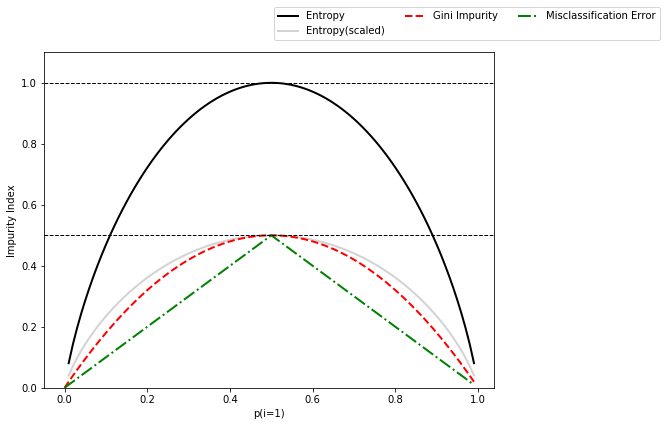

In [79]:
import matplotlib.pyplot as plt
import numpy as np

def gini(p):
    return 1 - (p * p + (1 - p) * (1 - p))

def entropy(p):
    return -p * np.log2(p) - (1 - p) * np.log2(1 - p)

def error(p):
    return 1 - np.max([p, 1 - p])

# 生成100个采样点
x = np.arange(0.0, 1.0, 0.01)

# 对p != 0的点计算熵，否则为None，第一个一定为None
ent = [entropy(p) if p != 0 else None for p in x]
# 缩放熵，对熵不为0的点，进行缩放
sc_ent = [e * 0.5 if e else None for e in ent]
# 计算所有概率的误分类率
err = [error(i) for i in x]

fig = plt.figure(figsize=(9, 6))
ax = plt.subplot(111)
for i, lab, ls, c in zip([ent, sc_ent, gini(x), err],
                         ['Entropy', 'Entropy(scaled)',
                          'Gini Impurity', 'Misclassification Error'],
                         ['-', '-', '--', '-.'],
                         ['black', 'lightgray', 'red', 'green', 'cyan']):
    # lw = linewidth
    line = plt.plot(x, i, label=lab, linestyle=ls, lw=2, color=c)
    
# bbox_to_anchor：表示legend的位置，前一个表示左右，后一个表示上下。当使用这个参数时。loc将不再起正常的作用，ncol=3表示图例三列显示。
# bbox_to_anchor可以讲图例在图表外显示，但这样会影响图的比例
ax.legend(loc='upper left', bbox_to_anchor=(0.5, 1.15),
          ncol=3, fancybox=True, shadow=False)

ax.axhline(y=0.5, linewidth=1, color='k', linestyle='--')
ax.axhline(y=1.0, linewidth=1, color='k', linestyle='--')
plt.ylim([0, 1.1])
plt.xlabel('p(i=1)')
plt.ylabel('Impurity Index')
plt.tight_layout()
plt.show()

### b. 构建决策树

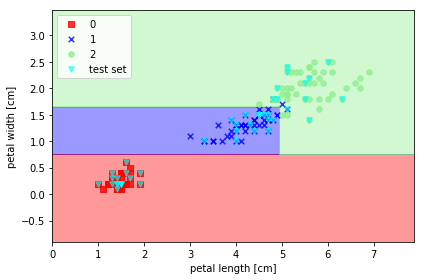

In [82]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)
tree.fit(X_train, y_train)

X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))
plot_decision_regions(X_combined, y_combined,
                      classifier=tree, test_idx=range(105,150))

plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

sklearn的一个好处就是可以将生成的决策树导出为dot格式的文件，这使得我们可以使用GraphViz程序对它进行可视化处理。

In [83]:
from sklearn.tree import export_graphviz
export_graphviz(tree, out_file='tree.dot', feature_names=['petal length', 'petal width'])

使用GraphViz可以将上面生成的决策树转化成PNG图片用于显示。

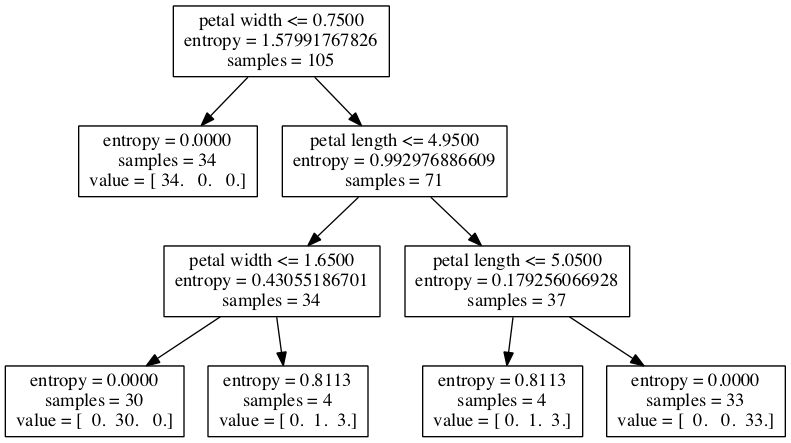

In [86]:
from IPython.display import Image
Image(filename='03_18.png', width=600) 

### c. 使用随机森林将弱分类器集成为强分类器
随机森林算法的过程：
1. 使用bootstrap抽样方法随机选择n个样本用于训练（从训练集中随机可重复的抽取）
2. 使用第一步的样本构造一个决策树，节点划分规则如下：<br>
    a. 不重复地随机选择d个特征；<br>
    b. 根据目标函数要求，如最大化信息增益，使用选定的特征对节点进行划分<br>
3. 重复上述过程1～2000次
4. 汇总每棵决策树的类标进行多数投票

我们通常不用对随机森林进行剪枝，在实践中，真正需要关心的参数是构建随机森林所需的决策树数量（步骤3）。

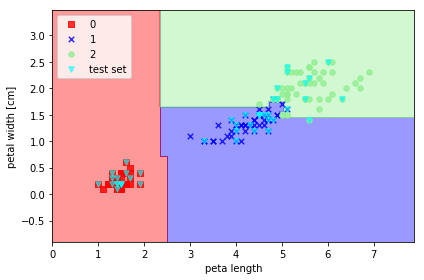

In [91]:
from sklearn.ensemble import RandomForestClassifier
# n_estimatros:训练使用的决策树数量
# n_jobs:训练中使用的处理器内核数量
forest = RandomForestClassifier(criterion='entropy',
                                n_estimators=10,
                                random_state=1,
                                n_jobs=2)

forest.fit(X_train, y_train)
plot_decision_regions(X_combined, y_combined, 
                      classifier=forest, test_idx=range(105, 150))

plt.xlabel('peta length')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

选择较多的基分类器，会提升模型的方差，过多的话会产生过拟合。

## 5. 惰性学习算法——k-近邻算法
惰性：kNN仅仅对数据集有记忆功能，并不会产生一个判别函数。

kNN算法：
1. 选择近邻的数量k和距离度量方法
2. 找到待分类样本的k个最近邻居
3. 根据最近邻的类标进行多数投票

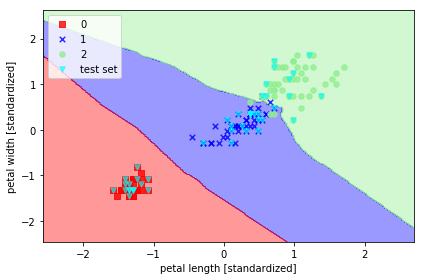

In [92]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5, p=2, metric='minkowski')

knn.fit(X_train_std, y_train)
plot_decision_regions(X_combined_std, y_combined, 
                      classifier=knn, test_idx=range(105, 150))

plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

就kNN来说，找到正确的k值是偏差-方差平衡的关键所在。在使用欧几里得距离时，对数据的标准化处理，保持各属性度量的尺度统一也是很重要的。
代码中的“闵可夫斯基(minkowski)”距离是对欧几里得距离和曼哈顿距离的泛化，可写作：
$$d(x^{(i)}, y^{(i)}) = \sqrt[q]{\sum_k{|x_k^{(i)}x_k^{(j)}|}^p}$$
可以看到，当参数$p=2$时就是欧几里得距离，$p=1$时就是曼哈顿距离。

维数灾难：<br>
对于一个样本数量大小稳定的训练数据集，随着其特征数量的增加，样本中有具体值的特征数量变得及其稀疏（也就是说样本矩阵是稀疏矩阵）。
使得在高维空间中不同样本的欧氏距离变得很大，之间的差异也趋近于0，收敛速度很慢。
https://www.zhihu.com/question/27836140

另一种解释（来自ESL）：<br>
假设N个点均匀分布在p维的单位球上，中心在原点，如果对中心原点进行一个k近邻估计，
中心原点到近邻数据点的平均距离为${(1-\frac{1}{2^N})}^{\frac1p}$。随着维数增加，这个值越来越接近1，大多数点接近于边界，使得点之间变得
稀疏，寻找最近邻就变得困难。这时就需要增加点的数量，进一步减慢了kNN的收敛速度。